In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2024-03-15 22:16:55.721586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 22:16:55.721706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 22:16:55.876783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Exploration

In [3]:
# Define directories for train, validation and test datasets 

train_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train'
test_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/BTTAIxNYBG-test'
val_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation/BTTAIxNYBG-validation'

In [4]:
# Define variables for train, test, val dataframes

train_data = pd.read_csv('/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train.csv')
val_data = pd.read_csv('/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation.csv')
test_data = pd.read_csv('/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test.csv')

In [5]:
# Glance at the dataframes
train_data.head()

,uniqueID,classLabel,classID,source,imageFile
0,2,occluded-specimens,8,L,a1a8b48e8cb142b3.jpg
1,3,microscope-slides,6,L,79599db2ac9092b6.jpg
2,4,illustrations-color,2,BHL,c449696f2f0d0d92.jpg
3,5,illustrations-color,2,P,80a8f4a393b4e08c.jpg
4,6,animal-specimens,0,AK,041a1c6e73313638.jpg


In [6]:
# Glance at the dataframes
val_data.head()

,uniqueID,classLabel,classID,source,imageFile
0,7,microscope-slides,6,K,f09a8abe9e9e9ef2.jpg
1,20,illustrations-color,2,BHL,a6c6868387c6af8c.jpg
2,37,ordinary-pressed-specimens,9,YU,6062c68e8c34b292.jpg
3,59,animal-specimens,0,CAS,363617271597dfd9.jpg
4,60,biocultural-specimens,1,Met,4218d8d2f42b05e4.jpg


In [7]:
test_data.head()

,uniqueID,imageFile
0,1,facd4dcd8e869617.jpg
1,9,78c96bb2b2b62579.jpg
2,10,d292d2c4e0e6ad9d.jpg
3,14,3633494929870713.jpg
4,16,dc94b496c8e2d6c4.jpg


In [8]:
# Printing class names
class_names = train_data['classLabel'].unique()

# Converting names into a list
class_names_list = class_names.tolist()

print(class_names_list)

['occluded-specimens', 'microscope-slides', 'illustrations-color', 'animal-specimens', 'live-plants', 'biocultural-specimens', 'illustrations-gray', 'mixed-pressed-specimens', 'ordinary-pressed-specimens', 'micrographs-transmission-light']


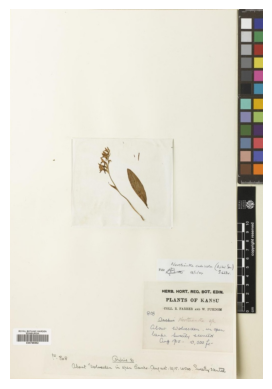

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

# Printing a random image from train_data
image_path = "/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/0000100c0c10c0c4.jpg"

# Open the image using PIL
image = Image.open(image_path)

# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

Due to the dataframes containing a large amount of imagees, it is neccessary to take a sample of each data frame before conducting any final testing. This can aid in troubleshooting issues that may arise during model training, preprocessing and augmentation

In [10]:
# Set the number of samples you want to select from each dataframe
num_samples = 800

# Randomly select samples from each dataframe
sample_train = train_data.sample(n=num_samples)
sample_test = test_data.sample(n=num_samples)
sample_val = val_data.sample(n=num_samples)

In [11]:
# Ensrue samples were taken correctly
sample_train.shape

(800, 5)

From the table we can see that the images were randomly selected and this is an extra step to ensure that the model does not underfit

In [12]:
sample_train.head()

,uniqueID,classLabel,classID,source,imageFile
61072,91552,mixed-pressed-specimens,7,MPU,1a33e1f3e5ae58a8.jpg
47800,71428,occluded-specimens,8,BR,8080a08488616187.jpg
50619,75688,biocultural-specimens,1,Met,e09e9e17171f3370.jpg
71414,107136,micrographs-transmission-light,5,Tw,62ac9a5318044c60.jpg
44171,66011,microscope-slides,6,L,b8b1c264f41ab2b2.jpg


# Image Preprocessing

In [13]:
def load_and_preprocess_image(image_data, target_size=(224, 224)):
    image_data = image_data / 255.0 # Rescale to [0, 1]
    layer = Normalization(mean=[0.485, 0.456, 0.406], 
                          variance=[np.square(0.299), 
                                    np.square(0.224), 
                                    np.square(0.225)])
    # tf.image.per_image_standardization(image_data)
    return layer(image_data)

In [14]:
datagen = ImageDataGenerator()
print(sample_train['classLabel'].value_counts())

classLabel
illustrations-color               102
ordinary-pressed-specimens         92
microscope-slides                  87
animal-specimens                   80
biocultural-specimens              79
mixed-pressed-specimens            79
micrographs-transmission-light     73
illustrations-gray                 72
occluded-specimens                 68
live-plants                        68
Name: count, dtype: int64


# Data Augmentation

In [15]:
# Data augmentation configuration for training
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40, # rotation_range=40,
    width_shift_range=0.15, # width_shift_range=0.2,
    height_shift_range=0.15, # height_shift_range=0.2,
    shear_range=0.15, # shear_range=0.2,
    zoom_range=0.15, # zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    # preprocessing_function=load_and_preprocess_image
)

In [16]:
# Note: No augmentation for validation data, only rescaling
validation_datagen = ImageDataGenerator(
    rescale=1./255 # happens in preprocessing func below
    # preprocessing_function=load_and_preprocess_image
)

In [17]:
# Convert dataframe to a format suitable for the model training
# https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
def df_to_dataset(dataframe, image_directory, datagen, batch_size=32):
    dataset = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=image_directory,
        x_col='imageFile',
        y_col='classLabel',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'  # Change this if not a multiclass classification
    )
    return dataset

In [18]:
# Create datasets for training and validation
train_dataset = df_to_dataset(sample_train, train_dir, train_datagen, 32)
validation_dataset = df_to_dataset(sample_val, val_dir, validation_datagen, 32)

Found 800 validated image filenames belonging to 10 classes.
Found 800 validated image filenames belonging to 10 classes.


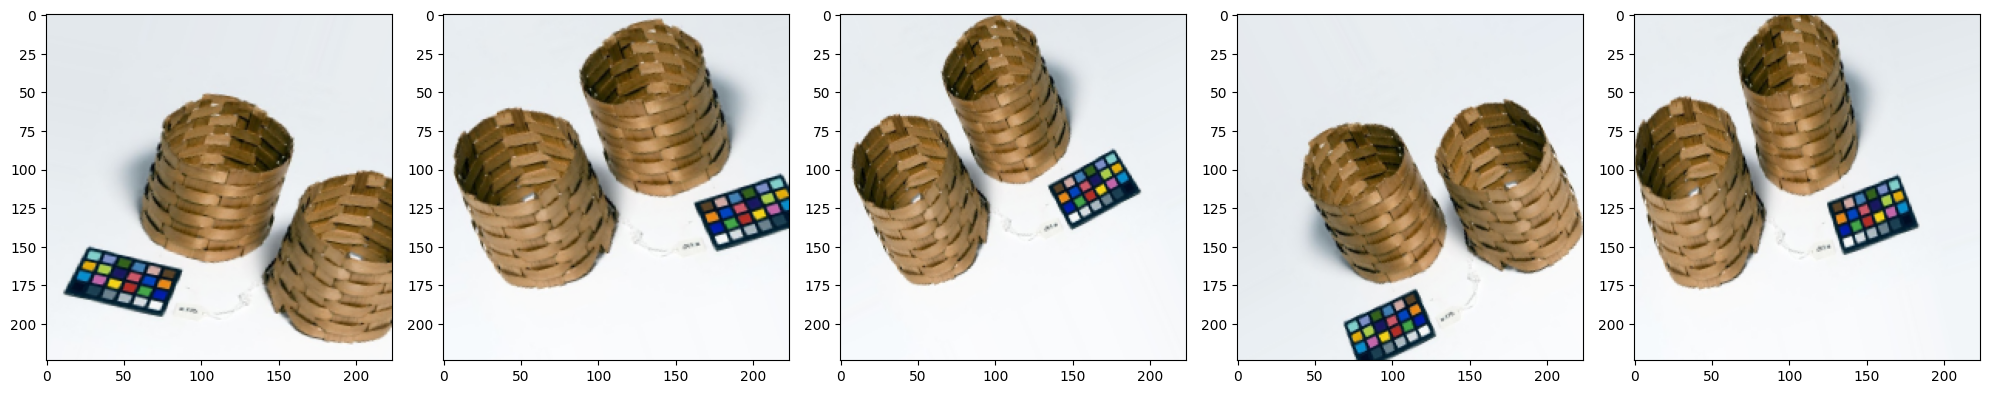

In [19]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

augmented_images = [train_dataset[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Create A CNN Model

In [20]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(224, 224, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=10, activation='softmax') #units are the number of classes in df
    ])
    
    return model

In [21]:
cnn_model = create_model()

In [22]:
print(cnn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 220, 220, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 110, 110, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 108, 108, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,538,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,643,498 (21.53 MB)

 Trainable params: 5,643,050 (21.53 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [23]:
# Defining callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [24]:
# Defining an optimizer 
optimizer = Adam(learning_rate=0.001)


In [25]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [26]:
history = cnn_model.fit(train_dataset, epochs=50, validation_data=validation_dataset,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50


I0000 00:00:1710541063.611915     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710541063.633806     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710541078.120191     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 - 52s - 2s/step - accuracy: 0.2950 - loss: 8.6544 - val_accuracy: 0.0938 - val_loss: 11.3678 - learning_rate: 0.0010
Epoch 2/50
25/25 - 20s - 812ms/step - accuracy: 0.4150 - loss: 8.1089 - val_accuracy: 0.1112 - val_loss: 11.5358 - learning_rate: 0.0010
Epoch 3/50
25/25 - 20s - 809ms/step - accuracy: 0.4563 - loss: 6.9731 - val_accuracy: 0.1300 - val_loss: 4.8318 - learning_rate: 0.0010
Epoch 4/50
25/25 - 20s - 818ms/step - accuracy: 0.4663 - loss: 6.1166 - val_accuracy: 0.0875 - val_loss: 6.2093 - learning_rate: 0.0010
Epoch 5/50
25/25 - 20s - 810ms/step - accuracy: 0.4762 - loss: 5.3722 - val_accuracy: 0.1550 - val_loss: 6.2997 - learning_rate: 0.0010
Epoch 6/50
25/25 - 20s - 804ms/step - accuracy: 0.4863 - loss: 4.3172 - val_accuracy: 0.1412 - val_loss: 4.5807 - learning_rate: 0.0010
Epoch 7/50
25/25 - 20s - 818ms/step - accuracy: 0.5263 - loss: 3.2478 - val_accuracy: 0.1562 - val_loss: 6.0525 - learning_rate: 0.0010
Epoch 8/50
25/25 - 20s - 803ms/step - accuracy: 0.5075 - los

# Plotting Model Metrics

In [27]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = cnn_model.optimizer.learning_rate


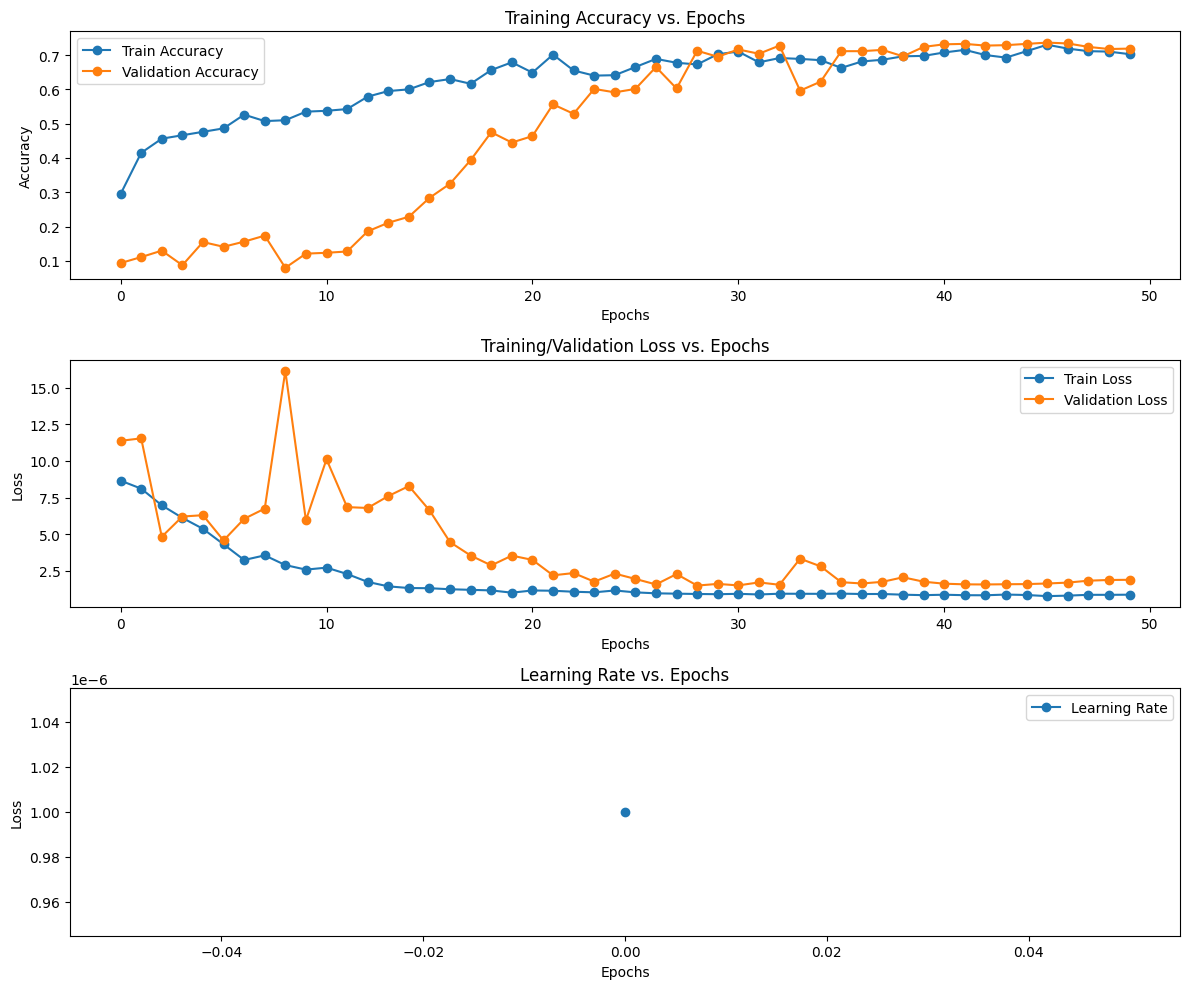

In [28]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()